## Cats and Dogs 이진 분류

### 이진분류 프로젝트

#### 개요
- 목표 : CNN으로 개와 고양이 이미지 분류 이진 분류기

#### Kaggle 데이터 다운로드
- 캐글이 뭐에요?
    - https://www.kaggle.com/
    - 예측모델 및 분석 대회 플랫폼. 2017년 구글이 인수    

1. Kaggle 계정 만들기
2. 설정 진입
    - https://www.kaggle.com/settings
    - API > Create New Token 클릭 Kaggle.json 다운로드

3. 파이썬 Kaggle 패키지 설치
```shell
!pip install kaggle
```

4. kaggle.json 파일위치
    - 리눅스/유닉스 : ~/.kaggle/kaggle.json
    - 윈도우 : %USERPROFILE%\.kaggle
        - 사용자 폴더 아래
    - 다운로드 받은 kaggle.json을 붙여넣기

5. https://www.kaggle.com/competitions/dogs-vs-cats/overview
    - Data탭에서 Join the competition 버튼 클릭

In [1]:
!pip install kaggle

  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/173.2 kB ? eta -:--:--
   ------------------------------------- -- 163.8/173.2 kB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 173.2/173.2 kB 3.5 MB/s eta 0:00:00
Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
   ---------------------------------------- 0.0/78.2 kB ? eta -:--:--
   ---------------------------------------- 78.2/78.2 kB 4.2 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 데이터셋 다운로드
!kaggle competitions download -c dogs-vs-cats

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/dogs-vs-cats


#### 데이터셋 전처리

In [3]:
# 파이썬 모듈로드
import os, shutil, random

In [ ]:
# 500개씩 샘플링 함수
def sample_data(src_dir, dst_dir, num_samples=500):
    os.makedirs(dst_dir, exist_ok=True)     # 폴더 생성, exist_ok = True 이미 존재하면 다시 만들지 않음
    all_files = [f for f in os.listdir(src_dir) if f.startswith(dst_dir.split('/')[-1])]
    samples = random.sample(all_files, num_samples)
    for f in samples:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir,f))

In [ ]:
# 폴더 정리
base_dir = './data/train'   # 원본폴더 25000개
cat_dir = './data/sample/cat'     # './data/sample/cat'/ 마지막에 / 추가하면 안됨  
dog_dir = './data/sample/dog'

In [9]:
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)


In [10]:
# sample_data() 함수 사용
sample_data(base_dir, cat_dir,500)
sample_data(base_dir, dog_dir,500)


<img src= '../image/ml0021.png' width = '600'>

#### 파이토치 시작!

- ImageFoler 클래스 - 폴더명을 자동으로 레이블로 변환
    - cat -> 0
    - dog -> 1

In [11]:
# 파이토치 모듈 로드
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [12]:
transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [13]:
train_dataset = ImageFolder('./data/sample', transform=transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle= True)

#### train_loader 시각화

In [15]:
# 시각화용 모듈 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
# 한글로 Matplotlib 사용시 항상 필요
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
rcParams['axes.unicode_minus'] = False

sns.set_style('darkgrid')
sns.set_theme(font='Malgun Gothic', rc={'axes.unicode_minus': False})

In [17]:
# 배치하나  꺼내기
images, labels = next(iter(train_loader))

In [23]:
class_names= ['cat', 'dog']

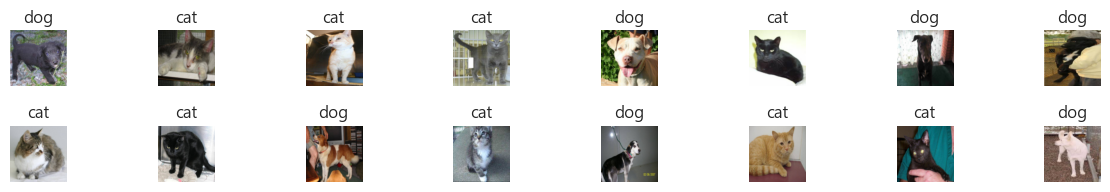

In [ ]:
# 시각화
plt.figure(figsize=(12,4))
for i in range(16): # 32개 중 반만 표현
    plt.subplot(4, 8, i+1)

    img = images[i].permute(1,2,0)  # 컬러채널이기 때문에 matplotlib 표현시 순서 변경
    plt.imshow(img)
    plt.title(f'{class_names[labels[i].item()]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### CNN 모델정의

In [46]:
# 사용모듈 로드
import torch
import torch.nn as nn
import torch.nn.functional as F

In [51]:
# 클래스 정의
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)   # conv1, conv2 모두 사용
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # MaxPool(128) -> MaxPool(64) -> 32x32
        self.fc2 = nn.Linear(128,1) # 마지막 분류가 0,1
    def forward(self, x):
        # conv -> activation -> maxpooling 2회실시
        # dense1, 2 통과
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 *32 * 32)             # flattern -> 1차원 배열화, 65,536개 입력
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))          # F.sigmoid() deprecated
        return x

#### 훈련

In [52]:
# cuda 준비
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatDogCNN().to(device)
criterion = nn.BCELoss()    # Binary Cross Entropy 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [49]:
# 훈련함수
def train(model, loader, criterion, optimizer):
    model.train()   # 훈련모드
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)     # 1, 0 -> [1,],[0,]
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss +=loss.item()

    return total_loss / len(loader)

In [54]:
# 훈련
EPOCH = 10
for epoch in range(EPOCH):
    loss = train(model, train_loader, criterion, optimizer )
    print(f'[{epoch+1}/{EPOCH}] Loss: {loss:4f}')

[1/10] Loss: 0.385403
[2/10] Loss: 0.268257
[3/10] Loss: 0.147951
[4/10] Loss: 0.089656
[5/10] Loss: 0.043524
[6/10] Loss: 0.025498
[7/10] Loss: 0.017831
[8/10] Loss: 0.012915
[9/10] Loss: 0.006153
[10/10] Loss: 0.002661


#### 예측결과 시각화

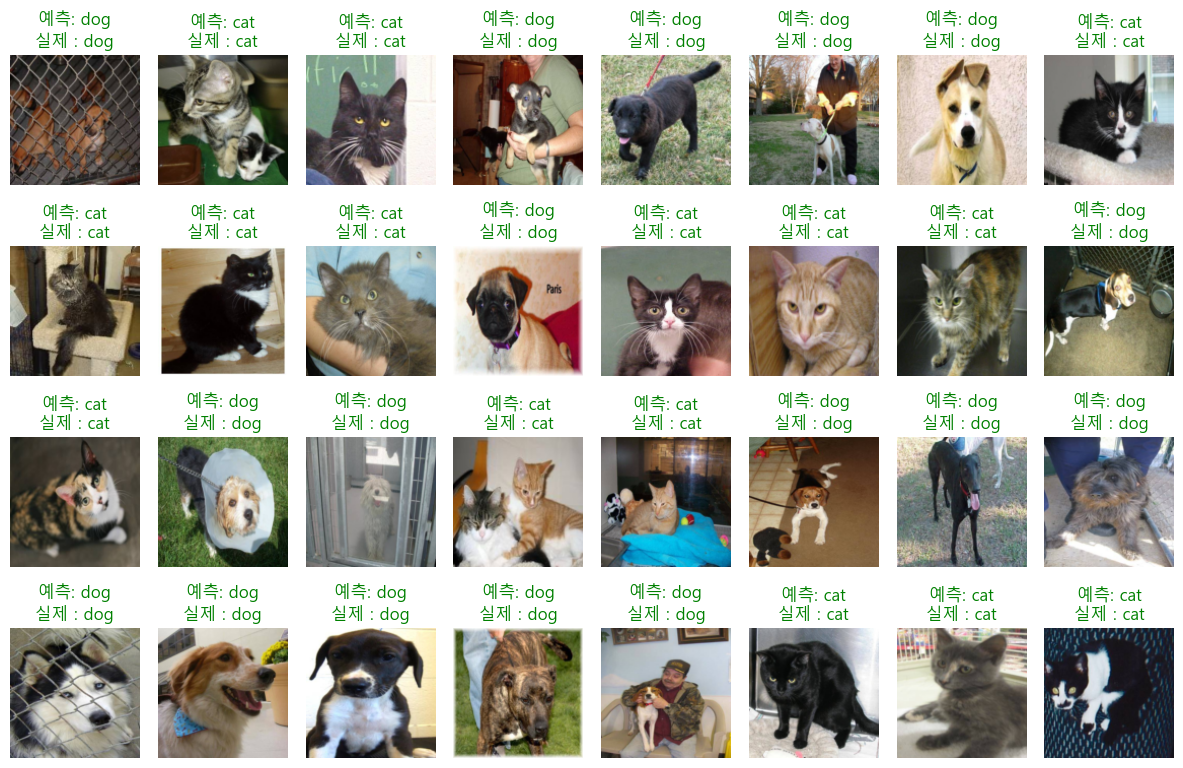

In [77]:
# 검증
model.eval()
images, labels = next(iter(train_loader))
images = images.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = (outputs > 0.5).int().cpu().squeeze()

plt.figure(figsize = (12, 8))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i].cpu().permute(1,2,0))
    pred_label = 'dog' if preds[i] == 1 else 'cat'
    true_label = 'dog' if labels[i] == 1 else 'cat'
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'예측: {pred_label}\n실제 : {true_label}', color = color)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 모델저장 / 불러오기

In [79]:
# 가중치만 저장
torch.save(model.state_dict(), './catdog_weight.pth')

In [80]:
# 모델전체 저장
torch.save(model, './catdog_model.pth')

In [81]:
# 가중치만 불러올때
model2 = CatDogCNN().to(device)
model2.load_state_dict(torch.load('./catdog_weight.pth', map_location= device))
model2

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)